## This notebook makes a dummy storage curve as pretend validation data and calculates an r squared value compared to the depth to surface area made from the wofs/depth gauge method

In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import six
import matplotlib
import matplotlib.pyplot as plt

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Loop over all files and make fake validation data

In [2]:
directory = 'Storage_curves'

#make a list of the file names so we can call them with pandas
file_list = []

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_list.append(os.path.join(directory, filename))

#Read the gauge files twice, once to get ID and second to get the data. Append them together in a dictionary
#May as well make a list of IDs here because we will use it later       
validation_df_list = []
#let's use tqdm again to make a progress bar. The bar is so cool I love this module
for i in file_list:
    df = pd.read_csv(i)
    # Get gauge ID
    ID = df.loc[0, 'ID']
    type_test = isinstance(ID, str)
    if type_test is False:
        ID = ID.astype(str)

    # Get first and last values
    length = len(df)
    last_n = length -1
    last = df.iloc[last_n]
    first = df.iloc[0]

    last_v = last['Surface Area']
    first_v = first['Surface Area']

    # Change first and last values a little bit
    first_v = first_v + (first_v * 0.05)
    last_v = last_v - (last_v * 0.05)

    # Change all values to 0 
    df['Surface Area'] = 0

    # Except for the first and last value
    df.loc[0, 'Surface Area'] = first_v
    df.loc[last_n, 'Surface Area'] = last_v

    # Interpolate between the changed first and last values
    df.drop(df[df['Surface Area'] == 0].index, inplace=True) #drop zero values
    df2 = df.set_index("Depth")
    min_ = df2.index.min()
    max_ = df2.index.max()
    df3 = df2.reindex(range(min_, max_+1))
    df3['Surface Area'] = df3['Surface Area'].interpolate()
    df3['ID'] = ID
    #df3.to_csv('../dea-notebooks/Supplementary_data/Reservoir_validation_data/'+ID+'_storage_curve.csv' )
    validation_df_list.append(df3)

KeyError: 'ID'

## Use just one storage curve and make fake validation data
Choose one of the storage curves you made in the box above

In [3]:
remotely_sensed = pd.read_csv('Storage_curves/419041.csv') #Keepit

In [4]:
# Get gauge ID
ID = remotely_sensed.loc[0, 'ID']
type_test = isinstance(ID, str)
if type_test is False:
    ID = ID.astype(str)

In [5]:
# Get first and last values
length = len(remotely_sensed)
last_n = length -1
last = remotely_sensed.iloc[last_n]
first = remotely_sensed.iloc[0]

last_v = last['Surface Area']
first_v = first['Surface Area']

# Change first and last values a little bit
first_v = first_v + (first_v * 0.05)
last_v = last_v - (last_v * 0.05)

## Make fake validation data by copying the remotely sensed data and changing it

In [6]:
df = remotely_sensed.copy()

In [7]:
# Change all values to 0 
df['Surface Area'] = 0
# Except for the first and last value
df.loc[0, 'Surface Area'] = first_v
df.loc[last_n, 'Surface Area'] = last_v

# Interpolate between the changed first and last values
df.drop(df[df['Surface Area'] == 0].index, inplace=True) #drop zero values
df2 = df.set_index("Depth")
min_ = df2.index.min()
max_ = df2.index.max()
df3 = df2.reindex(range(min_, max_+1))
df3['Surface Area'] = df3['Surface Area'].interpolate()
df3['ID'] = ID

In [8]:
rs_df = remotely_sensed.set_index('Depth') # this is the original curve
rs_df

,ID,Surface Area
Depth,,
306,419041,1772500.0
307,419041,2733437.5
308,419041,3694375.0
309,419041,4275312.5
310,419041,4856250.0
311,419041,6100937.5
312,419041,7345625.0
313,419041,8540000.0
314,419041,9734375.0


## Do Statistical tests to describe the likeness

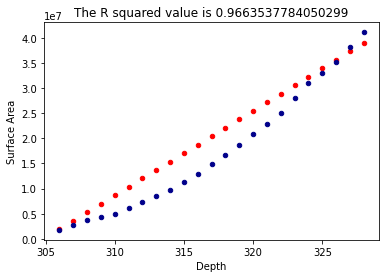

In [9]:
#Calculate r squared
real_list = rs_df['Surface Area'].to_list()
fake_list = df3['Surface Area'].to_list()

corr_matrix = np.corrcoef(real_list, fake_list)
corr = corr_matrix[0,1]
R2 = corr**2
R2_str = R2.astype(str)
title = 'The R squared value is ' + R2_str


# plot
rs_df['Depth'] = rs_df.index
df3['Depth'] = df3.index

ax = df3.plot.scatter(x='Depth',
                    y='Surface Area',
                    c='Red')
rs_df.plot.scatter(x='Depth',
                    y='Surface Area',
                    c='DarkBlue',
                    ax=ax, title = title)

We need to measure the difference between each point in the remotely sensed data and the 'validation' data, and then report the average difference. This is Chi.

In [10]:
#Calculate Chi squared
contingency = pd.DataFrame(index=rs_df.index)
contingency['Validation_Surface_Area'] = df3['Surface Area']
contingency['Remotley_Sensed_Surface_Area'] = rs_df['Surface Area']
contingency['difference'] = contingency['Remotley_Sensed_Surface_Area'] - contingency['Validation_Surface_Area']
average_difference = sum(contingency['difference']/len(contingency.index))

print('The average difference between the remotley sensed data and the validation data is:')
print(average_difference)

The average difference between the remotley sensed data and the validation data is:
-3126932.065217391


In [ ]:
# I went in excel and changed the fake validation data to be a different length and different intervals
# so I can write a code that can cope with validation data that's not the same length and intervals as the remotely sensed data
vd_df = pd.read_csv('Storage_curves/FAKE_Keepit_validation.csv')
vd_df

In [ ]:
print('The length of the validation data is ', len(vd_df))
print('The length of the remotely sensed data is ', len(rs_df))

In [ ]:
# because the validation might be a different range and different length and different values (on depth axis), you have to make them same.
# (practice coding this in with a different validation data)
# All of this can be done with np.interp(). Interpolate the remotely sensed data against the real data (use x values of real data) 
# remember you have to remove the end bits that are outside the remotely sensed range



## Input your own validation data

In [ ]:
v_data = pd.read_csv('../Supp')